In [ ]:
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split

**Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
image_set =  "/content/drive/MyDrive/lung_colon_image_set/lung_image_sets"

In [ ]:
SIZE_X = SIZE_Y = 224
#80% train data 20% test data
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,zoom_range=0.2,horizontal_flip=True,validation_split = 0.2)

train_set = datagen.flow_from_directory(image_set,
                                       class_mode = "categorical",
                                       target_size = (SIZE_X,SIZE_Y),
                                       batch_size = 32, 
                                       subset='training',
                                       seed = 42,
                                       )

Found 12013 images belonging to 3 classes.


**Model creation**

In [ ]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = Conv2D(filters = 256, kernel_size = (3,3), padding='same' ) (X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = Conv2D(filters = 256, kernel_size = (3,3), padding='same' ) (X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    X = Conv2D(filters = 256, kernel_size = (3,3), padding='same' ) (X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = Conv2D(filters = 512, kernel_size = (3,3), padding='same' ) (X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = Conv2D(filters = 512, kernel_size = (3,3), padding='same' ) (X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = Conv2D(filters = 512, kernel_size = (3,3), padding='same' ) (X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    X = Conv2D(filters = 512, kernel_size = (3,3), padding='same' ) (X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = Conv2D(filters = 1024, kernel_size = (3,3), padding='same' ) (X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = Conv2D(filters = 1024, kernel_size = (3,3), padding='same' ) (X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = Conv2D(filters = 1024, kernel_size = (3,3), padding='same' ) (X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = Conv2D(filters = 1024, kernel_size = (3,3), padding='same' ) (X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = Conv2D(filters = 1024, kernel_size = (3,3), padding='same' ) (X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = Conv2D(filters = 1024, kernel_size = (3,3), padding='same' ) (X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = Conv2D(filters = 2048, kernel_size = (3,3), padding='same' ) (X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = Conv2D(filters = 2048, kernel_size = (3,3), padding='same' ) (X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = Conv2D(filters = 2048, kernel_size = (3,3), padding='same' ) (X) 
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    headModel = Flatten()(X)
    headModel=Dense(512, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
    headModel=Dense(256, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
    headModel=Dense(128, activation='relu', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)
    headModel = Dense( 3,activation='sigmoid', name='fc4',kernel_initializer=glorot_uniform(seed=0))(headModel)
    model = Model(inputs=X_input, outputs=headModel, name='ResNet50')
    return model

In [ ]:
#Train From Scratch model
base_model = ResNet50(input_shape=(224, 224, 3))


In [ ]:
base_model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                           

In [ ]:
base_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=1e-04), metrics = ['accuracy'])

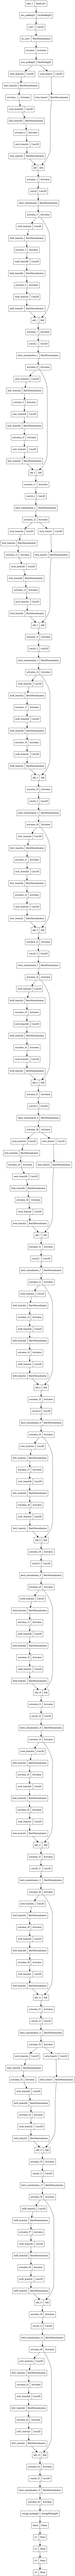

In [ ]:
tf.keras.utils.plot_model(
    base_model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

**Model training**

In [ ]:
H = base_model.fit_generator(train_set,epochs=5)

<ipython-input-13-dba65c71eeb4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = base_model.fit_generator(train_set,epochs=5)


Epoch 1/5
376/376 [==============================] - 3162s 8s/step - loss: 0.5146 - accuracy: 0.7844
Epoch 2/5
376/376 [==============================] - 438s 1s/step - loss: 0.2715 - accuracy: 0.8935
Epoch 3/5
376/376 [==============================] - 437s 1s/step - loss: 0.2227 - accuracy: 0.9183
Epoch 4/5
376/376 [==============================] - 437s 1s/step - loss: 0.1657 - accuracy: 0.9358
Epoch 5/5
376/376 [==============================] - 441s 1s/step - loss: 0.1546 - accuracy: 0.9421


**Saving the model**

In [ ]:
base_model.save("/kaggle/working/")

**Accuracy and loss**

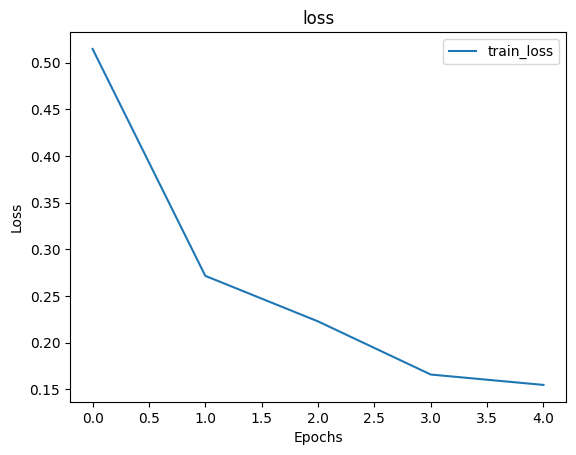

In [ ]:
# plotting the loss
import matplotlib.pyplot as plt
plt.plot(H.history['loss'],label = 'train_loss')
plt.title('loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

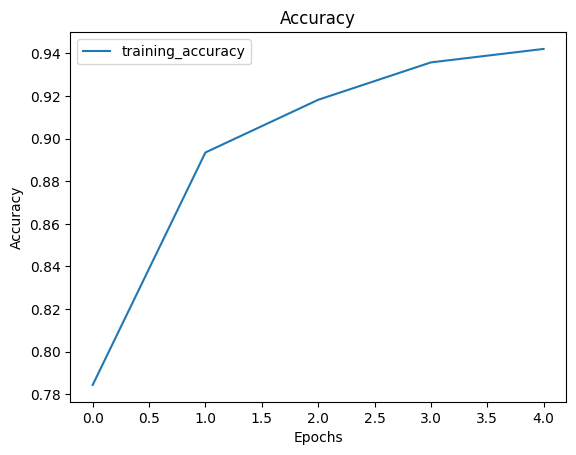

In [ ]:
# Both Validation and Training accuracy is shown here
plt.plot(H.history['accuracy'], label='training_accuracy')
plt.title('Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**Loading the model**


In [ ]:
base_model.save("/kaggle/working/Lung_Cancer_Resnet.h5")

In [ ]:
model=tf.keras.models.load_model("/content/drive/MyDrive/Lung Cancer Model/Lung_Cancer_Resnet.h5")

In [ ]:
!nvidia-smi

In [ ]:
#resnet
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [ ]:
# Both Validation and Training accuracy is shown here
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
#custom model
flatten = Flatten()(resnet.output)
layer1 = Dense(512, activation = 'relu')(flatten)
midlayer1 = Dense(512, activation = 'relu')(layer1)
midlayer2 = Dense(512, activation = 'relu')(midlayer1)
midlayer3 = Dense(512, activation = 'relu')(midlayer2)
midlayer4 = Dense(512, activation = 'relu')(midlayer3)
midlayer5 = Dense(512, activation = 'relu')(midlayer4)
midlayer6 = Dense(512, activation = 'relu')(midlayer5)
midlayer7 = Dense(512, activation = 'relu')(midlayer6)
midlayer8 = Dense(512, activation = 'relu')(midlayer7)
midlayer9 = Dense(512, activation = 'relu')(midlayer8)
midlayer10 = Dense(512, activation = 'relu')(midlayer9)
midlayer11 = Dense(512, activation = 'relu')(midlayer10)
midlayer12 = Dense(256, activation = 'relu')(midlayer11)
midlayer13 = Dense(256, activation = 'relu')(midlayer12)
midlayer14 = Dense(256, activation = 'relu')(midlayer13)
midlayer15 = Dense(256, activation = 'relu')(midlayer14)
midlayer16 = Dense(256, activation = 'relu')(midlayer15)
midlayer17 = Dense(256, activation = 'relu')(midlayer16)
midlayer18 = Dense(256, activation = 'relu')(midlayer17)
midlayer19 = Dense(256, activation = 'relu')(midlayer18)
midlayer20 = Dense(256, activation = 'relu')(midlayer19)
midlayer21 = Dense(256, activation = 'relu')(midlayer20)
midlayer22 = Dense(128, activation = 'relu')(midlayer21)
midlayer23 = Dense(128, activation = 'relu')(midlayer22)
midlayer24 = Dense(128, activation = 'relu')(midlayer23)
midlayer25 = Dense(128, activation = 'relu')(midlayer24)
midlayer26 = Dense(128, activation = 'relu')(midlayer25)
midlayer27 = Dense(128, activation = 'relu')(midlayer26)
midlayer28 = Dense(128, activation = 'relu')(midlayer27)
midlayer29 = Dense(128, activation = 'relu')(midlayer28)
midlayer30 = Dense(128, activation = 'relu')(midlayer29)
midlayer31 = Dense(128, activation = 'relu')(midlayer30)
midlayer32 = Dense(64, activation = 'relu')(midlayer31)
midlayer33 = Dense(64, activation = 'relu')(midlayer32)
midlayer34 = Dense(64, activation = 'relu')(midlayer33)
midlayer35 = Dense(64, activation = 'relu')(midlayer34)
midlayer36 = Dense(64, activation = 'relu')(midlayer35)
midlayer37 = Dense(64, activation = 'relu')(midlayer36)
midlayer38 = Dense(64, activation = 'relu')(midlayer37)
midlayer39 = Dense(64, activation = 'relu')(midlayer38)
midlayer40 = Dense(64, activation = 'relu')(midlayer39)
prediction = Dense(2, activation = 'softmax')(midlayer40)

In [ ]:
model = Model(inputs = resnet.input, outputs = prediction )

In [ ]:
model.summary()

In [ ]:
history = model.fit_generator(train_set, validation_data = (validate_set), epochs = 3, verbose = 1)

In [ ]:
result = model.evaluate(validate_set,batch_size=128)
print("test_loss, test accuracy",result)

**Model inference**

In [ ]:
Y_pred = model.predict_generator(validate_set)

In [ ]:
list(map(lambda x: np.argmax(x), Y_pred))

In [ ]:
import os, cv2
os.listdir("C:\Users\ANUMUKUNTH\Downloads\lung dataset/")[:3]

In [ ]:
from PIL import Image
from torchvision import transforms
import torch

img1 = Image.open("dataset/notmelanoma/ISIC_0024316.jpg").convert('RGB')
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])
img1 = preprocess(img1)
img1 = torch.unsqueeze(img1, 0)

In [ ]:
img1 = img1.reshape(1,224,224,3)
img1.shape

In [ ]:
Y_pred = model.predict_generator(np.array(img1))

In [ ]:
np.argmax(Y_pred)